<a href="https://colab.research.google.com/github/fajaralgii04/bigdata-uts-ganjil-2526-/blob/main/Kelompok5_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** KODE SCRAP UNTUK MEMANGGIL DATA DARI API STEAM **

In [14]:
# ============================================================
# 🔹 STEAM REVIEW SCRAPER — schema identik dgn Kaggle referensi
#    Kolom: 11 kolom [appid, review, word_count, voted_up, votes_up,
#                     votes_funny, timestamp_created, author_playtime_forever,
#                     name, price, release_date]
#    Catatan kesesuaian:
#    - price = cent (int64), bukan dibagi 100
#    - author_playtime_forever = menit (int64), bukan jam
#    - release_date = float64 (NaN), disamakan dengan file referensi
# ============================================================

# 1️⃣ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Import library
import os, time, requests
import pandas as pd
import numpy as np
from typing import Dict, Any, Optional
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter

# 3️⃣ Lokasi simpan
BASE_DIR = "/content/drive/MyDrive/BigData_Steam/data/raw"
os.makedirs(BASE_DIR, exist_ok=True)
OUTPUT_PATH = os.path.join(BASE_DIR, "steam_reviews_realtime_11cols.csv")

# 4️⃣ App list (bebas kamu ganti/extend)
APP_IDS = [
    570,      # Dota 2
    1172470,  # Apex Legends
    578080,   # PUBG: BATTLEGROUNDS
    271590,   # Grand Theft Auto V
]

# 5️⃣ Parameter scraping
MAX_REVIEWS_PER_APP = 2100
LANGUAGE = "english"
SLEEP_SEC = 1.0
MAX_RETRIES = 3
BACKOFF_BASE = 1.5
STORE_CC = "us"   # gunakan 'us' agar price_overview lebih konsisten; tetap output dlm cent

# 🔧 HTTP session (retry + UA)
session = requests.Session()
retry = Retry(
    total=5,
    backoff_factor=0.6,
    status_forcelist=(429, 500, 502, 503, 504),
    allowed_methods=frozenset(["GET"]),
)
session.mount("https://", HTTPAdapter(max_retries=retry))
HEADERS = {"User-Agent": "Mozilla/5.0 SteamReviewCollector/1.0 (Colab)"}

# 6️⃣ Skema & dtypes target (PERSIS seperti referensi)
REQUIRED_COLS = [
    "appid", "review", "word_count", "voted_up", "votes_up", "votes_funny",
    "timestamp_created", "author_playtime_forever", "name", "price", "release_date"
]
DTYPES_ENFORCE = {
    "appid": "int64",
    "review": "object",
    "word_count": "int64",
    "voted_up": "bool",
    "votes_up": "int64",
    "votes_funny": "int64",
    "timestamp_created": "int64",
    "author_playtime_forever": "int64",  # menit
    "name": "object",
    "price": "int64",                    # cent (tanpa /100)
    "release_date": "float64"            # NaN (float64), samakan dengan referensi
}

# 7️⃣ Ambil metadata app (name, price in cent, release_date=NaN biar float64)
_cache_appinfo: Dict[int, Dict[str, Any]] = {}

def get_app_details(app_id: int) -> Dict[str, Any]:
    if app_id in _cache_appinfo:
        return _cache_appinfo[app_id]

    url = "https://store.steampowered.com/api/appdetails"
    params = {"appids": app_id, "cc": STORE_CC, "l": "en"}

    for attempt in range(MAX_RETRIES):
        try:
            r = session.get(url, headers=HEADERS, params=params, timeout=20)
            r.raise_for_status()
            j = r.json()
            node = j.get(str(app_id), {})
            if node.get("success"):
                data = node.get("data", {}) or {}
                pov = data.get("price_overview") or {}
                is_free = bool(data.get("is_free", False))

                # 'final' = cent; simpan sebagai int64
                final_cent = pov.get("final")
                if is_free or final_cent is None:
                    price_cent = 0
                else:
                    # kadang float/str -> paksa ke int
                    price_cent = int(float(final_cent))

                result = {
                    "name": data.get("name") or "",
                    "price": price_cent,    # int64
                    "release_date": np.nan  # float64 NaN (samakan referensi)
                }
                _cache_appinfo[app_id] = result
                return result
        except Exception:
            time.sleep(BACKOFF_BASE ** attempt)

    # fallback
    result = {"name": "", "price": 0, "release_date": np.nan}
    _cache_appinfo[app_id] = result
    return result

# 8️⃣ Scrape review per app
def fetch_reviews_for_app(app_id: int, max_reviews: int) -> pd.DataFrame:
    rows, cursor, pulled = [], "*", 0
    seen = set()

    meta = get_app_details(app_id)
    g_name, g_price, g_release = meta["name"], meta["price"], meta["release_date"]

    while pulled < max_reviews:
        url = f"https://store.steampowered.com/appreviews/{app_id}"
        params = {
            "json": 1,
            "cursor": cursor,
            "num_per_page": 100,
            "filter": "recent",
            "language": LANGUAGE,
            "review_type": "all",
            "purchase_type": "all",
        }

        ok, data = False, None
        for attempt in range(MAX_RETRIES):
            try:
                resp = session.get(url, headers=HEADERS, params=params, timeout=30)
                resp.raise_for_status()
                data = resp.json()
                ok = True
                break
            except Exception:
                time.sleep(BACKOFF_BASE ** attempt)

        if not ok or not data or "reviews" not in data:
            break

        revs = data.get("reviews") or []
        if not revs:
            break

        for rv in revs:
            txt = (rv.get("review") or "").strip()
            if not txt:
                continue

            # playtime dalam MENIT (int64)
            pt_min = (rv.get("author") or {}).get("playtime_forever")
            try:
                pt_min = int(pt_min) if pt_min is not None else 0
            except Exception:
                pt_min = 0

            rows.append({
                "appid": int(app_id),
                "review": txt,
                "word_count": int(len(txt.split())),
                "voted_up": bool(rv.get("voted_up")),
                "votes_up": int(rv.get("votes_up") or 0),
                "votes_funny": int(rv.get("votes_funny") or 0),
                "timestamp_created": int(rv.get("timestamp_created") or 0),
                "author_playtime_forever": pt_min,   # menit (int)
                "name": g_name,
                "price": int(g_price or 0),          # cent (int)
                "release_date": g_release            # float64 NaN
            })

        pulled += len(revs)

        next_cursor = data.get("cursor")
        if not next_cursor or next_cursor in seen:
            break
        seen.add(next_cursor)
        cursor = next_cursor

        time.sleep(SLEEP_SEC)
        if pulled >= max_reviews:
            break

    df = pd.DataFrame(rows)

    # Pastikan semua kolom ada & urutan sama
    for c in REQUIRED_COLS:
        if c not in df.columns:
            df[c] = np.nan
    df = df[REQUIRED_COLS]

    return df

# 9️⃣ Jalankan untuk semua app
frames = []
for app in APP_IDS:
    print(f"[INFO] Fetch up to {MAX_REVIEWS_PER_APP} for app_id={app} ...")
    df_app = fetch_reviews_for_app(app, MAX_REVIEWS_PER_APP)
    got = len(df_app)
    label = df_app["name"].iloc[0] if got else str(app)
    print(f" -> Got {got} rows for {label}")
    frames.append(df_app)

df_s = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=REQUIRED_COLS)

# 🔟 Enforce dtype PERSIS (int64/bool/object/float64)
# - int64 tidak menerima NaN → isi 0 dulu supaya dtype tetap int64
int_cols = ["appid","word_count","votes_up","votes_funny","timestamp_created","author_playtime_forever","price"]
for c in int_cols:
    df_s[c] = pd.to_numeric(df_s[c], errors="coerce").fillna(0).astype("int64")

df_s["voted_up"] = df_s["voted_up"].astype(bool)
df_s["review"] = df_s["review"].astype(object)
df_s["name"] = df_s["name"].astype(object)
df_s["release_date"] = pd.to_numeric(df_s["release_date"], errors="coerce").astype("float64")

# Optional: drop duplicates (appid + timestamp + review)
if not df_s.empty:
    before = len(df_s)
    df_s = df_s.drop_duplicates(subset=["appid","timestamp_created","review"])
    after = len(df_s)
    if after != before:
        print(f"[INFO] Dropped duplicates: {before - after}")

# Simpan
df_s = df_s[REQUIRED_COLS]
df_s.to_csv(OUTPUT_PATH, index=False)
print(f"\n✅ Saved to: {OUTPUT_PATH}")
print(f"Total rows: {len(df_s)}")

print("\n[SUMMARY] dtypes:")
print(df_s.dtypes)

print("\n[SUMMARY] Rows per app_id:")
print(df_s.groupby("appid")["review"].count().sort_values(ascending=False))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Fetch up to 2100 for app_id=570 ...
 -> Got 2093 rows for Dota 2
[INFO] Fetch up to 2100 for app_id=1172470 ...
 -> Got 2093 rows for Apex Legends™
[INFO] Fetch up to 2100 for app_id=578080 ...
 -> Got 2189 rows for PUBG: BATTLEGROUNDS
[INFO] Fetch up to 2100 for app_id=271590 ...
 -> Got 2091 rows for Grand Theft Auto V Legacy
[INFO] Dropped duplicates: 31

✅ Saved to: /content/drive/MyDrive/BigData_Steam/data/raw/steam_reviews_realtime_11cols.csv
Total rows: 8435

[SUMMARY] dtypes:
appid                        int64
review                      object
word_count                   int64
voted_up                      bool
votes_up                     int64
votes_funny                  int64
timestamp_created            int64
author_playtime_forever      int64
name                        object
price                        int64
release_date             

** KODE UNTUK MENGGABUNGKAN DATA SET KAGGLE DAN SCRAP **

In [16]:
# ======================================================
# 🔹 MERGE DATASET: Kaggle + Steam Scraping
# ======================================================

import pandas as pd
import os

# 1️⃣ Lokasi file (ubah sesuai path kamu di Drive)
kaggle_path = "/content/drive/MyDrive/BigData_Steam/data/raw/steam_game_reviews_top10_21000.csv"
scrape_path = "/content/drive/MyDrive/BigData_Steam/data/raw/steam_reviews_realtime_11cols.csv"

# 2️⃣ Baca dataset
df_kaggle = pd.read_csv(kaggle_path)
df_scrape = pd.read_csv(scrape_path)

print("Kaggle shape :", df_kaggle.shape)
print("Scrape shape :", df_scrape.shape)

# 3️⃣ Samakan nama kolom & tipe data (jaga konsistensi)
common_cols = [
    "appid", "review", "word_count", "voted_up", "votes_up", "votes_funny",
    "timestamp_created", "author_playtime_forever", "name", "price", "release_date"
]

df_kaggle = df_kaggle[common_cols].copy()
df_scrape = df_scrape[common_cols].copy()

# Pastikan dtype sama
df_scrape["voted_up"] = df_scrape["voted_up"].astype(bool)
df_kaggle["voted_up"] = df_kaggle["voted_up"].astype(bool)

# 4️⃣ Gabungkan
df_all = pd.concat([df_kaggle, df_scrape], ignore_index=True)

print("\n✅ Gabungan Berhasil!")
print(f"Total Rows: {len(df_all):,}")
print(f"Total Columns: {len(df_all.columns)}")

# 5️⃣ Cek missing values per kolom
print("\n[INFO] Missing Value (%) per Kolom:")
print((df_all.isna().mean() * 100).round(2))

# 6️⃣ Simpan ke folder processed
save_dir = "/content/drive/MyDrive/BigData_Steam/data/processed"
os.makedirs(save_dir, exist_ok=True)

output_path = os.path.join(save_dir, "steam_reviews_combined.csv")
df_all.to_csv(output_path, index=False)

print(f"\n💾 File gabungan disimpan di:\n{output_path}")


Kaggle shape : (16507, 11)
Scrape shape : (8435, 11)

✅ Gabungan Berhasil!
Total Rows: 24,942
Total Columns: 11

[INFO] Missing Value (%) per Kolom:
appid                        0.00
review                       0.01
word_count                   0.00
voted_up                     0.00
votes_up                     0.00
votes_funny                  0.00
timestamp_created            0.00
author_playtime_forever      0.00
name                         0.00
price                        0.00
release_date               100.00
dtype: float64

💾 File gabungan disimpan di:
/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_combined.csv


** CLEANING **

In [17]:
import pandas as pd

# 1. Load data
df = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_combined.csv")

# 2. Cek struktur dan null
print(df.info())
print(df.isna().sum())

# 3. Hapus baris kosong atau review tanpa teks
df = df.dropna(subset=["review"])

# 4. Hapus duplikat (berdasarkan kombinasi appid + review + timestamp)
df = df.drop_duplicates(subset=["appid", "review", "timestamp_created"])

# 5. Ubah tipe data
df["voted_up"] = df["voted_up"].astype(bool)
df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], unit="s")
df["word_count"] = pd.to_numeric(df["word_count"], errors="coerce").fillna(0).astype(int)
df["price"] = pd.to_numeric(df["price"], errors="coerce").fillna(0).astype(int)

# 6. Tangani outlier (misal, playtime ekstrem)
q_low = df["author_playtime_forever"].quantile(0.01)
q_high = df["author_playtime_forever"].quantile(0.99)
df = df[(df["author_playtime_forever"] >= q_low) & (df["author_playtime_forever"] <= q_high)]

# 7. Simpan hasil cleaning
output_path = "/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_clean.csv"
df.to_csv(output_path, index=False)
print(f"✅ Data cleaned saved to: {output_path}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24942 entries, 0 to 24941
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   appid                    24942 non-null  int64  
 1   review                   24940 non-null  object 
 2   word_count               24942 non-null  int64  
 3   voted_up                 24942 non-null  bool   
 4   votes_up                 24942 non-null  int64  
 5   votes_funny              24942 non-null  int64  
 6   timestamp_created        24942 non-null  int64  
 7   author_playtime_forever  24942 non-null  int64  
 8   name                     24942 non-null  object 
 9   price                    24942 non-null  int64  
 10  release_date             0 non-null      float64
dtypes: bool(1), float64(1), int64(7), object(2)
memory usage: 1.9+ MB
None
appid                          0
review                         2
word_count                     0
voted_up      

**Preprocessing **

In [18]:
# ======================================================
# 🔹 DATA PREPROCESSING — Steam Reviews Big Data Project
#    (sesuai pipeline: setelah cleaning, sebelum modeling)
# ======================================================

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# 0) Path I/O
IN_PATH  = "/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_clean.csv"
OUT_DIR  = "/content/drive/MyDrive/BigData_Steam/data/processed"
OUT_PATH = os.path.join(OUT_DIR, "steam_reviews_preprocessed.csv")

os.makedirs(OUT_DIR, exist_ok=True)

# 1) Load & cek ringkas
df = pd.read_csv(IN_PATH)
print("✅ Loaded:", IN_PATH, "| shape:", df.shape)
print(df.head(2), "\n")

print("INFO BEFORE:\n", df.info(), "\n")
print("MISSING BEFORE:\n", df.isna().sum(), "\n")

# 2) Drop kolom yang tidak dipakai untuk model numerik awal
drop_cols = ["appid", "name", "release_date", "review"]  # 'review' teks mentah (NLP nanti)
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# 3) Pastikan tipe & tangani NaN kolom numerik inti
num_cols = ["word_count", "votes_up", "votes_funny", "author_playtime_forever", "price"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

# Target kolom
if "voted_up" in df.columns:
    # pastikan boolean
    df["voted_up"] = df["voted_up"].astype(bool)
else:
    raise ValueError("Kolom 'voted_up' tidak ditemukan di dataset cleaned.")

# (opsional) Jika timestamp masih integer dan kamu butuh untuk EDA waktu, bisa konversi terpisah
# if "timestamp_created" in df.columns and pd.api.types.is_numeric_dtype(df["timestamp_created"]):
#     df["timestamp_created_dt"] = pd.to_datetime(df["timestamp_created"], unit="s")

# 4) Feature engineering sederhana
def bucket_wc(x: float) -> str:
    return "short" if x < 20 else ("medium" if x < 100 else "long")

df["review_length"] = df["word_count"].apply(bucket_wc)

# (opsional) fitur jam main — tidak wajib kalau sudah pakai menit
# df["playtime_hours"] = df["author_playtime_forever"] / 60.0

# 5) Encoding kategorikal
le = LabelEncoder()
df["review_length_encoded"] = le.fit_transform(df["review_length"])

# 6) Scaling fitur numerik (standarisasi)
scale_cols = [c for c in num_cols if c in df.columns]
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# 7) Simpan hasil preprocessed (siap untuk modeling)
df.to_csv(OUT_PATH, index=False)
print(f"💾 Saved preprocessed dataset: {OUT_PATH} | shape: {df.shape}")

print("\nINFO AFTER:\n", df.info(), "\n")
print("MISSING AFTER:\n", df.isna().sum(), "\n")
print("Preview cols:", df.columns.tolist())

# 8) (Opsional) Split train–test untuk klasifikasi 'voted_up'
FEATURE_COLS = [c for c in (num_cols + ["review_length_encoded"]) if c in df.columns]
TARGET_COL   = "voted_up"

X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].astype(bool).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"\n✅ Split done. Train: {len(X_train)}, Test: {len(X_test)}")
print("Features used:", FEATURE_COLS)

# (opsional) Simpan split ke CSV agar modeling tinggal load
X_train.to_csv(os.path.join(OUT_DIR, "X_train.csv"), index=False)
X_test.to_csv(os.path.join(OUT_DIR, "X_test.csv"), index=False)
y_train.to_csv(os.path.join(OUT_DIR, "y_train.csv"), index=False)
y_test.to_csv(os.path.join(OUT_DIR, "y_test.csv"), index=False)
print("💾 Saved train/test splits to:", OUT_DIR)


✅ Loaded: /content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_clean.csv | shape: (24461, 11)
   appid                                             review  word_count  \
0  42700  Honestly the best call of duty ever, insane cr...          67   
1  42710  One of the last good call of duty games, reall...          20   

   voted_up  votes_up  votes_funny    timestamp_created  \
0      True         7            0  2024-10-27 15:38:06   
1      True         0            0  2023-01-01 04:24:33   

   author_playtime_forever                     name  price  release_date  
0                     2237  Call of Duty: Black Ops   3999           NaN  
1                      640  Call of Duty: Black Ops   3999           NaN   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24461 entries, 0 to 24460
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   appid                    24461 non-null 

**Muhammad Fajar Algifari (1103223119)**

**Pertanyaan 1** (SMART – Apa & Dimana)

Pada periode 1 Januari – 31 Maret 2025, seberapa kuat hubungan antara durasi bermain dan kemungkinan review positif pada setiap game?
Game mana yang menunjukkan korelasi Pearson paling kuat antara durasi bermain dan tingkat kepuasan pemain?

/tmp/ipython-input-2792149035.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corrs = df.groupby("name").apply(safe_corr).dropna().sort_values(ascending=False).head(10)


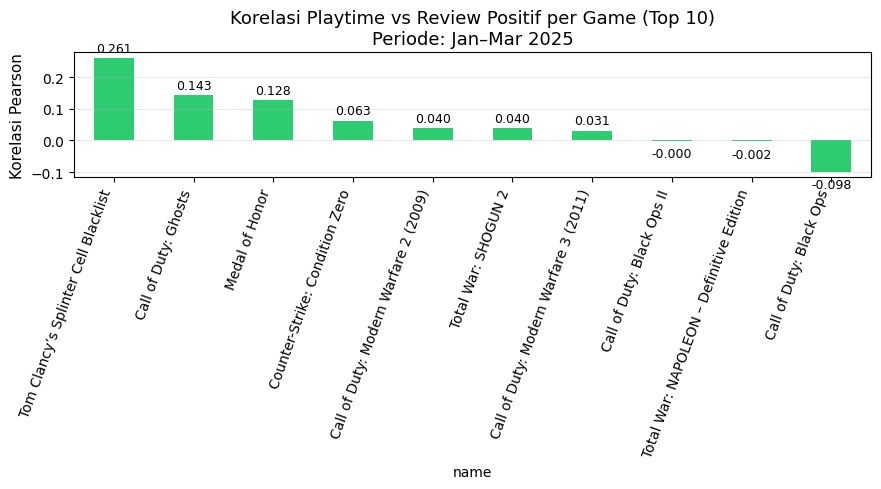

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === 1️⃣ Load data ===
df = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_clean.csv")

# === 2️⃣ Filter time-bound (mis. Q1 2025) ===
df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")
df = df[(df["timestamp_created"] >= "2025-01-01") & (df["timestamp_created"] < "2025-04-01")]

# === 3️⃣ Pastikan tidak ada NaN di kolom utama ===
df = df.dropna(subset=["name", "author_playtime_forever", "voted_up"])

# === 4️⃣ Hitung korelasi Pearson per game ===
def safe_corr(x):
    if x["author_playtime_forever"].nunique() > 1 and x["voted_up"].nunique() > 1:
        return x["author_playtime_forever"].corr(x["voted_up"].astype(int))
    else:
        return np.nan

corrs = df.groupby("name").apply(safe_corr).dropna().sort_values(ascending=False).head(10)

# === 5️⃣ Plot ===
plt.figure(figsize=(9,5))
corrs.plot(kind="bar", color="#2ecc71")  # hijau lembut, tetap readable
plt.title("Korelasi Playtime vs Review Positif per Game (Top 10)\nPeriode: Jan–Mar 2025", fontsize=13)
plt.ylabel("Korelasi Pearson", fontsize=11)
plt.grid(axis="y", alpha=0.3)
plt.xticks(rotation=70, ha="right")

# Tambahkan nilai korelasi di atas batang
for i, v in enumerate(corrs.values):
    plt.text(i, v + (0.01 if v >= 0 else -0.02), f"{v:.3f}", ha="center",
             va="bottom" if v >= 0 else "top", fontsize=9, color="black")

plt.tight_layout()
plt.show()


**Pertanyaan 2** (SMART – Kapan & Bagaimana)

Selama periode 1 Januari – 31 Maret 2025, bagaimana perubahan proporsi review positif (voted_up) dari minggu ke minggu, dan apakah terdapat pola tren peningkatan atau penurunan pada tingkat kepuasan pemain di berbagai game populer di platform Steam?

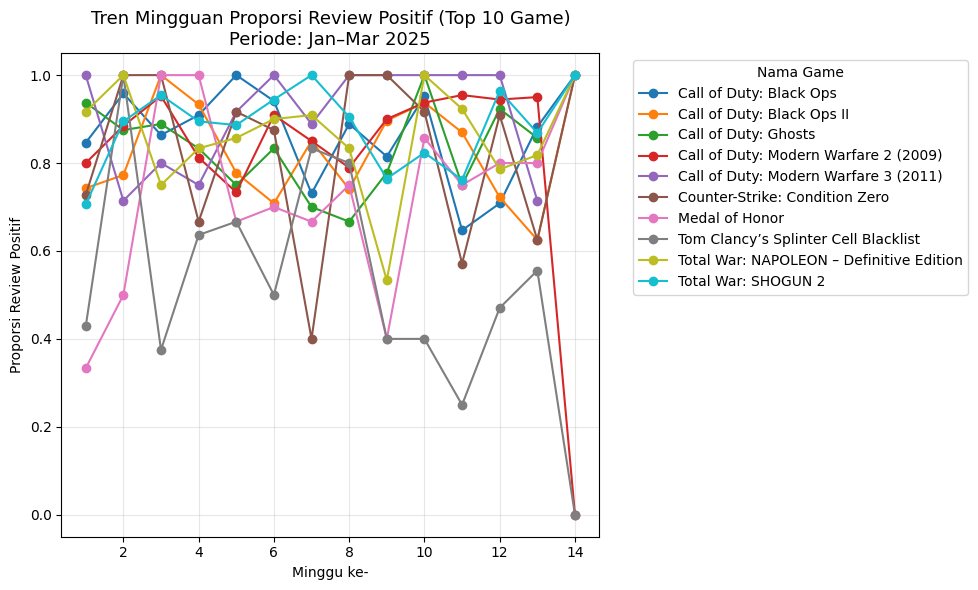

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1️⃣ Load dataset ===
df = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_clean.csv")

# === 2️⃣ Konversi waktu & filter periode Jan–Mar 2025 ===
df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")
df = df[(df["timestamp_created"] >= "2025-01-01") & (df["timestamp_created"] < "2025-04-01")]

# === 3️⃣ Ambil 10 game dengan review terbanyak ===
top_games = df["name"].value_counts().head(10).index
df_top = df[df["name"].isin(top_games)]

# === 4️⃣ Tambah kolom minggu ke-n (dari tanggal) ===
df_top["week"] = df_top["timestamp_created"].dt.isocalendar().week

# === 5️⃣ Hitung proporsi review positif per minggu per game ===
weekly_trend = (
    df_top.groupby(["name", "week"])["voted_up"]
    .mean()
    .reset_index()
    .rename(columns={"voted_up": "proporsi_positif"})
)

# === 6️⃣ Plot garis per game ===
plt.figure(figsize=(10,6))
for game in weekly_trend["name"].unique():
    game_data = weekly_trend[weekly_trend["name"] == game]
    plt.plot(game_data["week"], game_data["proporsi_positif"], marker='o', label=game)

plt.title("Tren Mingguan Proporsi Review Positif (Top 10 Game)\nPeriode: Jan–Mar 2025", fontsize=13)
plt.xlabel("Minggu ke-")
plt.ylabel("Proporsi Review Positif")
plt.legend(title="Nama Game", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**pertanyaan 3** (SMART – Mengapa & Siapa)

Sejauh mana tingkat keterlibatan komunitas (jumlah interaksi seperti votes_up, votes_funny, dan word_count) berkorelasi dengan kemungkinan review positif (voted_up) pada platform Steam selama periode 1 Januari – 31 Maret 2025?
Game mana yang menunjukkan hubungan paling kuat antara keterlibatan pemain dan sentimen positif?

/tmp/ipython-input-738097754.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("name").apply(safe_corr)


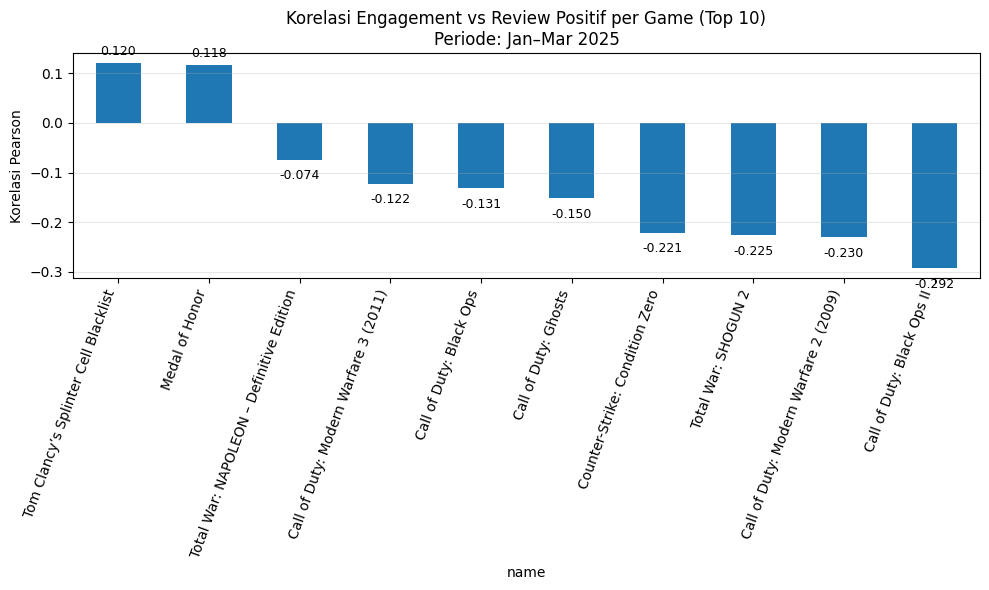

/tmp/ipython-input-738097754.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("eng_q")["voted_up_int"]


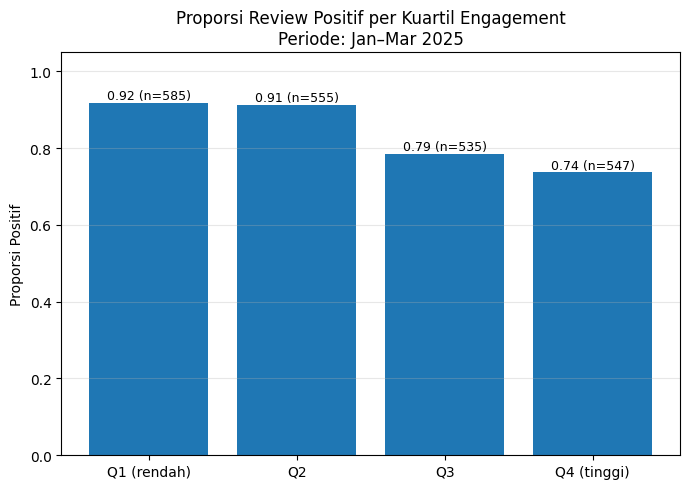

== Top-10 Game dengan Korelasi Engagement↔Positivity ==
                                          corr_engagement_positive
name                                                              
Tom Clancy’s Splinter Cell Blacklist                         0.120
Medal of Honor                                               0.118
Total War: NAPOLEON – Definitive Edition                    -0.074
Call of Duty: Modern Warfare 3 (2011)                       -0.122
Call of Duty: Black Ops                                     -0.131
Call of Duty: Ghosts                                        -0.150
Counter-Strike: Condition Zero                              -0.221
Total War: SHOGUN 2                                         -0.225
Call of Duty: Modern Warfare 2 (2009)                       -0.230
Call of Duty: Black Ops II                                  -0.292

== Positive Rate per Kuartil Engagement ==
         eng_q  pos_rate(%)    n
0  Q1 (rendah)        91.79  585
1           Q2        91.35  5

In [57]:
# =========================
# EDA PERTANYAAN 3 (Fajar)
# Engagement ↔ Positivity
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) Load & Time-bound ----
PATH = "/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_clean.csv"
df = pd.read_csv(PATH, parse_dates=["timestamp_created"], low_memory=False)

# Periode SMART: Jan–Mar 2025
start, end = "2025-01-01", "2025-04-01"  # end exclusive
df = df[(df["timestamp_created"] >= start) & (df["timestamp_created"] < end)].copy()

# Pastikan kolom tersedia
required = {"name","voted_up","votes_up","votes_funny","word_count"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}")

# Bersihkan NaN penting
df = df.dropna(subset=["name","voted_up","votes_up","votes_funny","word_count"]).copy()
df["voted_up_int"] = df["voted_up"].astype(int)

# ---- 2) Engagement score & winsorize (anti-outlier) ----
df["engagement_score"] = df["votes_up"].clip(lower=0) + df["votes_funny"].clip(lower=0) + df["word_count"].clip(lower=0)

# winsorize di p99 agar korelasi tidak didominasi outlier panjang/viral
p99 = df["engagement_score"].quantile(0.99)
df["engagement_score_w"] = np.minimum(df["engagement_score"], p99)

# ---- 3) Korelasi Pearson per game ----
def safe_corr(g):
    # syarat variasi & sampel
    if g["engagement_score_w"].nunique() < 2 or g["voted_up_int"].nunique() < 2 or len(g) < 20:
        return np.nan
    return g["engagement_score_w"].corr(g["voted_up_int"])

corrs = (
    df.groupby("name").apply(safe_corr)
      .dropna()
      .sort_values(ascending=False)
)

top10 = corrs.head(10)

# ---- 4) Plot 1: Top-10 korelasi per game ----
plt.figure(figsize=(10,6))
top10.plot(kind="bar")
plt.title(f"Korelasi Engagement vs Review Positif per Game (Top 10)\nPeriode: Jan–Mar 2025")
plt.ylabel("Korelasi Pearson")
plt.xticks(rotation=70, ha="right")
plt.grid(axis="y", alpha=0.3)
# label angka
for i, v in enumerate(top10.values):
    plt.text(i, v + (0.01 if v>=0 else -0.02), f"{v:.3f}", ha="center",
             va="bottom" if v>=0 else "top", fontsize=9)
plt.tight_layout()
plt.show()

# ---- 5) Plot 2: Positive rate per kuartil engagement (global) ----
# Bagi ke Q1-Q4 berdasarkan engagement_score_w
df["eng_q"] = pd.qcut(df["engagement_score_w"], 4, labels=["Q1 (rendah)","Q2","Q3","Q4 (tinggi)"])
quart = (
    df.groupby("eng_q")["voted_up_int"]
      .agg(pos_rate="mean", n="size")
      .reset_index()
)

plt.figure(figsize=(7,5))
plt.bar(quart["eng_q"].astype(str), quart["pos_rate"])
plt.title("Proporsi Review Positif per Kuartil Engagement\nPeriode: Jan–Mar 2025")
plt.ylabel("Proporsi Positif")
for i, (rate, n) in enumerate(zip(quart["pos_rate"], quart["n"])):
    plt.text(i, rate + 0.01, f"{rate:.2f} (n={n})", ha="center", fontsize=9)
plt.ylim(0, 1.05)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ---- 6) Cetak ringkas angka kunci (opsional untuk narasi) ----
print("== Top-10 Game dengan Korelasi Engagement↔Positivity ==")
print(top10.to_frame("corr_engagement_positive").round(3))

print("\n== Positive Rate per Kuartil Engagement ==")
print(quart.assign(pos_rate=(quart["pos_rate"]*100).round(2)).rename(columns={"pos_rate":"pos_rate(%)"}))


**Auldy Ranayu Sanny Prahasty Rachman (1103223216)**

Pertanyaan 1 (SMART – Apa & Mengapa)

Pada periode 1 Januari – 31 Maret 2025, bagaimana hubungan antara jumlah kata dalam review (word_count) dengan kemungkinan review positif (voted_up), dan mengapa hubungan tersebut dapat terjadi?

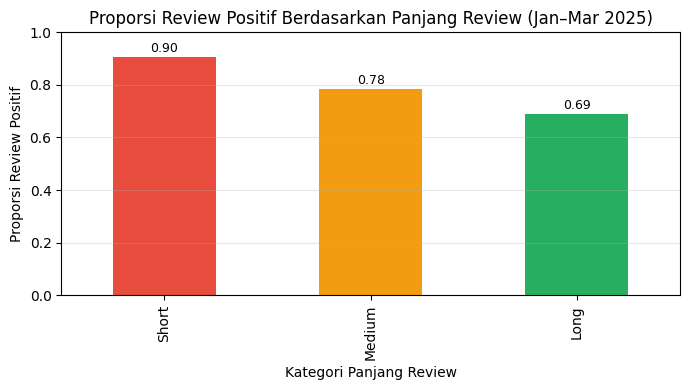

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load data dan filter waktu
df = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_clean.csv")
df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")
df = df[(df["timestamp_created"] >= "2025-01-01") & (df["timestamp_created"] < "2025-04-01")]

# 2️⃣ Kategorisasi panjang review
def cat_len(x):
    if x < 20:
        return "Short"
    elif x < 100:
        return "Medium"
    else:
        return "Long"

df["review_length_cat"] = df["word_count"].apply(cat_len)

# 3️⃣ Hitung proporsi review positif per kategori
ratio = (
    df.groupby("review_length_cat")["voted_up"]
      .mean()
      .reindex(["Short", "Medium", "Long"])
)

# 4️⃣ Visualisasi
plt.figure(figsize=(7,4))
ratio.plot(kind="bar", color=["#e74c3c", "#f39c12", "#27ae60"])
plt.title("Proporsi Review Positif Berdasarkan Panjang Review (Jan–Mar 2025)")
plt.ylabel("Proporsi Review Positif")
plt.xlabel("Kategori Panjang Review")
plt.ylim(0,1)
plt.grid(axis="y", alpha=0.3)

# Label nilai
for i, v in enumerate(ratio.values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


Pertanyaan 2 (SMART – Dimana & Bagaimana)

Pada periode 1 Januari – 31 Maret 2025, game mana yang memiliki tingkat keterlibatan (engagement) tertinggi berdasarkan jumlah interaksi pemain (votes_up dan votes_funny), dan bagaimana keterlibatan tersebut tercermin dalam jumlah rata-rata vote yang diterima?


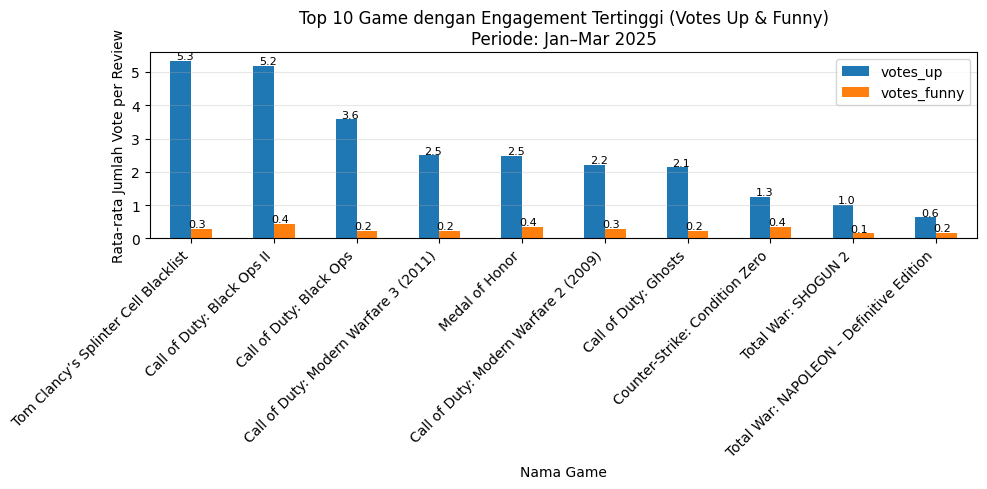

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load data & filter periode waktu
df = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_clean.csv")
df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")
df = df[(df["timestamp_created"] >= "2025-01-01") & (df["timestamp_created"] < "2025-04-01")]

# 2️⃣ Hitung engagement rata-rata per game
eng = (
    df.groupby("name")[["votes_up", "votes_funny"]]
      .mean()
      .sort_values("votes_up", ascending=False)
      .head(10)
)

# 3️⃣ Visualisasi top 10 game dengan engagement tertinggi
eng.plot(kind="bar", figsize=(10,5))
plt.title("Top 10 Game dengan Engagement Tertinggi (Votes Up & Funny)\nPeriode: Jan–Mar 2025")
plt.ylabel("Rata-rata Jumlah Vote per Review")
plt.xlabel("Nama Game")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)

# Tambahkan label angka di atas batang
for i, col in enumerate(eng.columns):
    for x, y in enumerate(eng[col].values):
        plt.text(x + (i-0.5)*0.15, y + 0.05, f"{y:.1f}", ha="center", fontsize=8)

plt.tight_layout()
plt.show()


Pertanyaan 3 (SMART – Kapan & Siapa):

Pada periode Januari–Desember 2025, kapan aktivitas pemain paling tinggi terjadi, dan game mana yang memiliki pertumbuhan jumlah review paling konsisten sepanjang tahun?


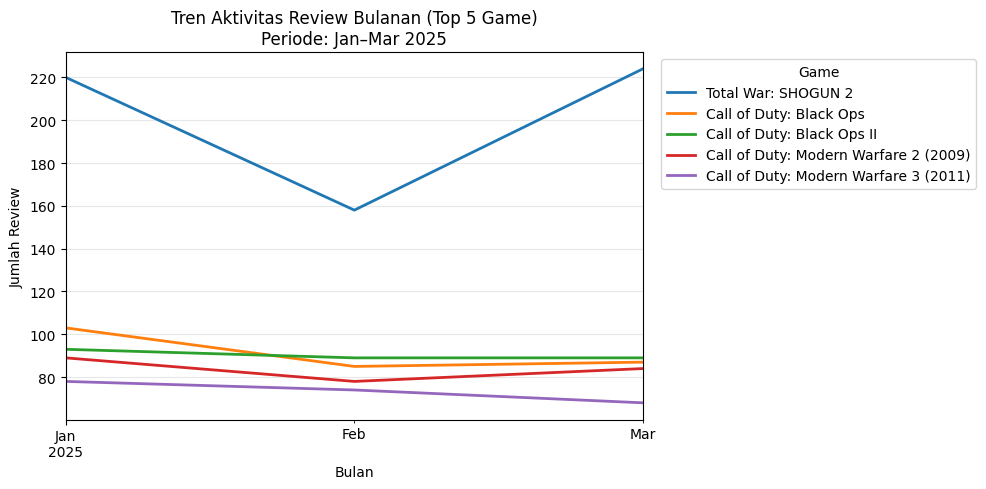

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load data dan konversi waktu
df = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_clean.csv")
df["timestamp_created"] = pd.to_datetime(df["timestamp_created"], errors="coerce")

# 2️⃣ Tambah kolom bulan (Month-Year)
df["month"] = df["timestamp_created"].dt.to_period("M").dt.to_timestamp()

# 3️⃣ Filter periode Januari–Maret 2025
df = df[(df["month"] >= "2025-01-01") & (df["month"] < "2025-04-01")]

# 4️⃣ Agregasi jumlah review per game per bulan
monthly_game = df.groupby(["name", "month"]).size().unstack(0).fillna(0)

# 5️⃣ Pilih 5 game dengan total review terbanyak
top_games = monthly_game.sum().sort_values(ascending=False).head(5).index

# 6️⃣ Visualisasi tren bulanan review
monthly_game[top_games].plot(figsize=(10,5), linewidth=2)
plt.title("Tren Aktivitas Review Bulanan (Top 5 Game)\nPeriode: Jan–Mar 2025")
plt.xlabel("Bulan")
plt.ylabel("Jumlah Review")
plt.legend(title="Game", bbox_to_anchor=(1.02,1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


-

-

-

-

KLASIFIKASI

Memprediksi apakah review pemain bersifat positif (voted_up=True) atau negatif (False).


=== SVM ===
Akurasi : 0.821
Presisi : 0.823
Recall  : 0.996
F1-Score: 0.901


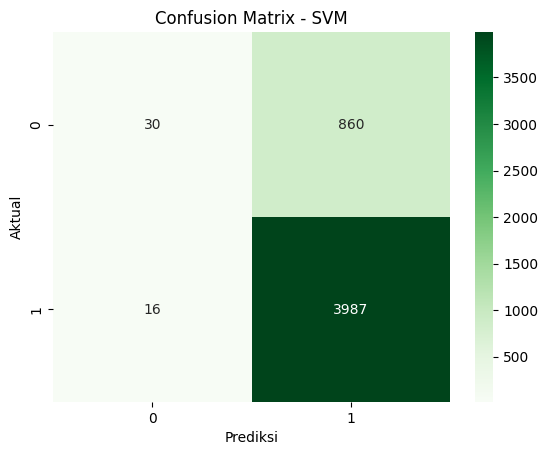


=== Random Forest ===
Akurasi : 0.803
Presisi : 0.859
Recall  : 0.908
F1-Score: 0.883


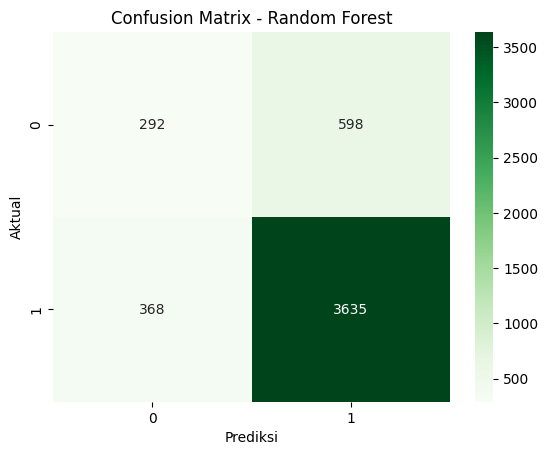

In [78]:
# ==========================================
# 🔹 KLASIFIKASI: SVM dan RANDOM FOREST
# ==========================================

import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Load data hasil preprocessing
X_train = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/X_train.csv")
X_test  = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/X_test.csv")
y_train = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/y_train.csv").squeeze()
y_test  = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/y_test.csv").squeeze()

# 2️⃣ Model SVM
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# 3️⃣ Model Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 4️⃣ Evaluasi fungsi umum
def eval_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"Akurasi : {acc:.3f}")
    print(f"Presisi : {pre:.3f}")
    print(f"Recall  : {rec:.3f}")
    print(f"F1-Score: {f1:.3f}")
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Greens")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Prediksi")
    plt.ylabel("Aktual")
    plt.show()

# 5️⃣ Evaluasi kedua model
eval_model("SVM", y_test, y_pred_svm)
eval_model("Random Forest", y_test, y_pred_rf)


B. REGRESI — LINEAR REGRESSION & XGBOOST
Tujuan:

Memprediksi jumlah upvotes (votes_up) yang diterima oleh sebuah review.

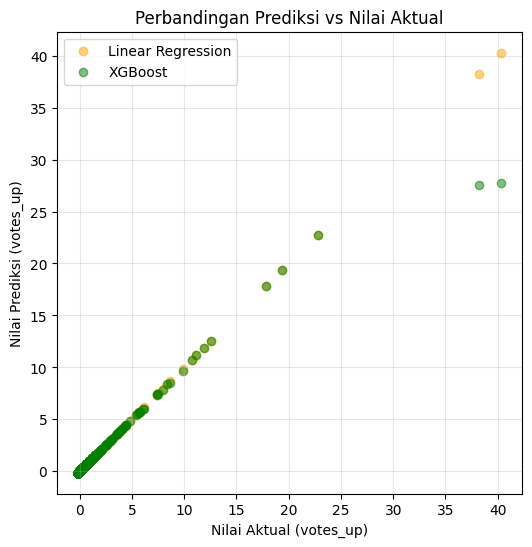

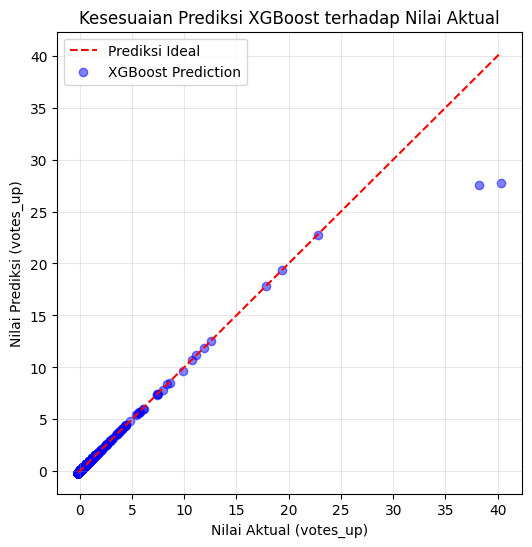


=== Linear Regression ===
MSE : 0.000
RMSE: 0.000
R²  : 1.000

=== XGBoost ===
MSE : 0.056
RMSE: 0.236
R²  : 0.956


In [77]:
# ==========================================
# 🔹 REGRESI: LINEAR REGRESSION & XGBOOST
# ==========================================

import pandas as pd
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# ==========================================
# 🔹 VISUALISASI HASIL REGRESI
# ==========================================
import matplotlib.pyplot as plt

# Scatter plot antara nilai aktual dan prediksi
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, pred_lr, alpha=0.5, label="Linear Regression", color='orange')
plt.scatter(y_test_reg, pred_xgb, alpha=0.5, label="XGBoost", color='green')
plt.xlabel("Nilai Aktual (votes_up)")
plt.ylabel("Nilai Prediksi (votes_up)")
plt.title("Perbandingan Prediksi vs Nilai Aktual")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Garis diagonal (ideal prediction)
plt.figure(figsize=(6, 6))
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', label="Prediksi Ideal")
plt.scatter(y_test_reg, pred_xgb, alpha=0.5, color='blue', label="XGBoost Prediction")
plt.xlabel("Nilai Aktual (votes_up)")
plt.ylabel("Nilai Prediksi (votes_up)")
plt.title("Kesesuaian Prediksi XGBoost terhadap Nilai Aktual")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 1️⃣ Load data
X_train = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/X_train.csv")
X_test  = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/X_test.csv")

# Target: votes_up
y_train_reg = X_train["votes_up"]
y_test_reg  = X_test["votes_up"]

# 2️⃣ Model Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train_reg)
pred_lr = lr.predict(X_test)

# 3️⃣ Model XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train_reg)
pred_xgb = xgb.predict(X_test)

# 4️⃣ Evaluasi fungsi umum
def eval_reg(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MSE : {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²  : {r2:.3f}")

# 5️⃣ Evaluasi hasil model
eval_reg("Linear Regression", y_test_reg, pred_lr)
eval_reg("XGBoost", y_test_reg, pred_xgb)



CLUSTERING — K-MEANS & DBSCAN
Tujuan:

Mengelompokkan game berdasarkan pola engagement pemain (unsupervised learning).

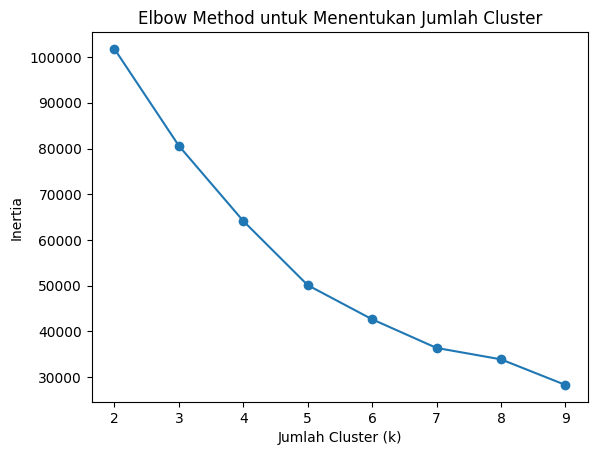

Silhouette Score K-Means: 0.380
Silhouette Score DBSCAN : 0.301


In [76]:
# ==========================================
# 🔹 CLUSTERING: K-MEANS & DBSCAN
# ==========================================

import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1️⃣ Load dataset numerik
X = pd.read_csv("/content/drive/MyDrive/BigData_Steam/data/processed/steam_reviews_preprocessed.csv")
X_num = X[["word_count","votes_up","votes_funny","author_playtime_forever","price"]]

# 2️⃣ Tentukan jumlah cluster optimal dengan Elbow Method
inertia = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_num)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'o-')
plt.title("Elbow Method untuk Menentukan Jumlah Cluster")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia")
plt.show()

# 3️⃣ Jalankan model K-Means dan DBSCAN
kmeans = KMeans(n_clusters=3, random_state=42)
dbscan = DBSCAN(eps=0.5, min_samples=5)

labels_km = kmeans.fit_predict(X_num)
labels_db = dbscan.fit_predict(X_num)

# 4️⃣ Evaluasi Silhouette Score
score_km = silhouette_score(X_num, labels_km)
score_db = silhouette_score(X_num, labels_db)

print(f"Silhouette Score K-Means: {score_km:.3f}")
print(f"Silhouette Score DBSCAN : {score_db:.3f}")

